In [1]:
from google.colab import drive
drive.mount('/content/drive')
# going to the repository of this note book
%cd drive/My Drive/DIQ
!ls

Mounted at /content/drive
/content/drive/My Drive/DIQ
10_PROJECTS.ipynb			       duplication_sim40_evaluation_before.pkl
7_DATA_DEDUPLICATION.ipynb		       duplication_sim80_evaluation_after.pkl
A_data_collection.py			       duplication_sim80_evaluation_before.pkl
data_to_pickle_after_duplication_remove.pkl    duplication_speed_all_40_after.csv
D_data_analysis.py			       duplication_speed_all_40_before.csv
duplication_distance_all_40_after.csv	       duplication_speed_all_80_after.csv
duplication_distance_all_40_before.csv	       duplication_speed_all_80_before.csv
duplication_distance_all_80_after.csv	       E_plot_results.py
duplication_distance_all_80_before.csv	       main.py
duplication.ipynb			       __pycache__
duplication_mean_perf_all_80_after.csv	       test
duplication_mean_perf_all_80_before.csv        test.pkl
duplication_perf_all_40-80_before.csv	       Untitled0.ipynb
duplication_perf_all_40_after.csv	       variable_type_distance_all.csv
duplication_perf_all_40_before.

In [2]:
!pip install python-Levenshtein pyphonetics jaro-winkler recordlinkage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.9/926.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.7 MB/s eta 0:00:00


#Importing libraries

In [3]:
pip install recordlinkage

In [4]:
import pandas as pd
import numpy as np
import pickle
import recordlinkage
from A_data_collection import make_dataset_for_classification, make_dataset_for_regression, make_dataset_for_clustering
from D_data_analysis import classification, clustering, regression,encoding_categorical_variables
from E_plot_results import plot
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.preprocessing import LabelEncoder

## External functions:

**Idea is to making a dataset with 10 features that all are numeric.**

In [ ]:
def data_generation():
    """
    This function will generate a dataset with 10 features that all are numeric.
    :return:
    """
    X, y = make_dataset_for_classification(
        n_samples=1000,
        n_features=10,
        n_informative=5,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        n_clusters_per_class=2,
        weights=None,
        flip_y=0.01,
        class_sep=1.0,
        scale=2,
        hypercube=True,
        seed=SEED
    )
    X = pd.DataFrame(X)
    column_mapping = {old_col: chr(ord('A') + i) for i, old_col in enumerate(X.columns)}
    X.rename(columns=column_mapping, inplace=True)
    print(10 * '-', 'percentage of the data that seperated between  different classes', 10 * '-')
    label_percentages = {label: len(y[y == label]) / len(y) * 100 for label in np.unique(y)}
    print('The percentage of each class', label_percentages)

    print(15 * '-', 'print the general information about extracted data', 15 * '-')
    print(pd.DataFrame(X).describe())

    #check duplication in row data that we are generating

    print(20 * '-', 'checking duplications per each column', 20 * '-')
    for i in pd.DataFrame(X).columns:
        duplicated_rows = X[X.duplicated(subset=i, keep=False)]
        print(f'column number {i} contains {len(duplicated_rows)} duplications')

    print(10 * '-', 'first time performance evaluation to get overall estimation', 10 * '-')
    # testing generated data on a classification algorithm to have a view about rough performance
    results_1_analysis = classification(X, y, 'DecisionTree', 2023)

    print('performance', results_1_analysis)
    return X, y


In [ ]:
def duplication_creation(X, y, similarity_percentage=20, duplication_percentage=5):
    """
    This function will create duplication in the data. It will create duplication in the data based on the similarity_percentage and duplication_percentage.
    :param X:
    :param y:
    :param similarity_percentage:
    :param duplication_percentage:
    :return:
    """
    num_samples, num_features = X.shape

    similarity_percentage = similarity_percentage
    duplication_percentage = duplication_percentage

    num_samples_to_duplicate = int(num_samples * duplication_percentage / 100)

    indices_to_duplicate = np.random.choice(num_samples, size=num_samples_to_duplicate, replace=False)

    num_features_to_duplicate = int(num_features * (100 - similarity_percentage) / 100)
    features_to_duplicate = np.random.choice(num_features, size=num_features_to_duplicate, replace=False)

    duplicated_X = X.iloc[indices_to_duplicate].copy()
    duplicated_Y = y[indices_to_duplicate].copy()

    for col_index in range(num_features):
        if col_index in features_to_duplicate:
            min_value = np.min(X.iloc[:, col_index])
            max_value = np.max(X.iloc[:, col_index])
            noise = np.random.uniform(low=-0.1 * (max_value - min_value), high=0.1 * (max_value - min_value),
                                      size=num_samples_to_duplicate)
            duplicated_X.iloc[:, col_index] += noise

    new_X = np.vstack([X, duplicated_X])
    new_Y = np.concatenate([y, duplicated_Y])

    shuffle_indices = np.arange(new_X.shape[0])
    np.random.shuffle(shuffle_indices)
    new_X = pd.DataFrame(new_X[shuffle_indices])
    new_Y = pd.DataFrame(new_Y[shuffle_indices])
    print(f'\n\n{num_samples_to_duplicate} duplicated samples added to the data\n')
    print(f'\n{features_to_duplicate} feature chnaged while we are creating duplications and the rest remained same.\n')
    return new_X, new_Y



In [ ]:
def duplication_detection(X, y, similarity):
    """
    This function will detect duplication in the data. It will detect duplication in the data based on the similarity_percentage.
    :param X:
    :param y:
    :param similarity:
    :return:
    """
    indexer = recordlinkage.Index()
    #indexer.random(int((len(X)*len(X)-len(X))/4))
    indexer.full()
    candidate_links = indexer.index(X)
    print(f'{len(candidate_links)} linkage created')
    duplicated_indexes = []
    for tuple_index in candidate_links:
        index = compare_indexes(X, tuple_index, similarity)
        if index is not None:
            duplicated_indexes.append(index)
    X = X.drop(index=duplicated_indexes).reset_index(drop=True)
    # Remove rows from NumPy array
    mask = np.ones(len(y), dtype=bool)
    mask[duplicated_indexes] = False
    y = y[mask]
    return X, y



In [ ]:
# Function to compare columns and print indexes
def compare_indexes(X, tuple_index, similarity):
    """
    This function will compare two rows of the data, and if the similarity between them is more than similarity_percentage,
    it will return the index of the second row.
    :param X:
    :param tuple_index:
    :param similarity:
    :return:
    """
    index1, index2 = tuple_index
    rows1 = pd.DataFrame(X).loc[index1]
    rows2 = pd.DataFrame(X).loc[index2]
    similarity_percentage = (np.sum(rows1 == rows2) / 10) * 100
    if similarity_percentage >= similarity:
        return index2

#Evaluation:

In [ ]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

SEED = 2023

if __name__ == '__main__':

    print("Main ...")

    # A: DATA COLLECTION
    X,y=data_generation()
    similarity_list=[40,80]
    duplication_rate=[5,10,15,20,25,30,35,40,45,50]
    results_1_analysis={algo: {sim: {dup: None for dup in duplication_rate} for sim in similarity_list} for algo in CLASSIFICATION_ALGORITHMS}
    results_2_analysis={algo: {sim: {dup: None for dup in duplication_rate} for sim in similarity_list} for algo in CLASSIFICATION_ALGORITHMS}
    results_per_similarity_rate=[]
    results_per_algorithm=[]

    # B: DATA POLLUTION

    for algorithm in CLASSIFICATION_ALGORITHMS:
      for similarity in similarity_list:
        for duplication in duplication_rate:
          data_x,data_y=duplication_creation(X,y,similarity,duplication)
          data_y = data_y.values.ravel()
          # saving performance should be managed here
          results_1_analysis[algorithm][similarity][duplication]=classification(data_x, data_y, algorithm, SEED)
          data_x,data_y=duplication_detection(data_x,data_y,similarity)
          data_y = data_y.ravel()
          # saving performance should be managed here
          results_2_analysis[algorithm][similarity][duplication]=classification(data_x, data_y, algorithm, SEED)



Main ...
---------- percentage of the data that seperated between  different classes ----------
The percentage of each class {0: 50.0, 1: 50.0}
--------------- print the general information about extracted data ---------------
                 A            B            C            D            E  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.050225    -1.117695    -0.825849    -0.022423     0.052929   
std       2.013510     2.837436     3.290502     3.122238     2.100679   
min      -7.405301    -8.972575    -9.095387    -9.212033    -6.416585   
25%      -1.189006    -3.029575    -2.985284    -2.314307    -1.427058   
50%       0.099050    -1.376553    -1.005527     0.332614     0.069972   
75%       1.473058     0.686619     1.417480     2.269123     1.422872   
max       6.273003     7.069745     9.500800     8.322083     7.128648   

                 F            G            H            I            J  
count  1000.000000  1000.000000  

#If you run the code again please save the results

In [ ]:
pickle_file_path = 'duplication_sim40-80_evaluation_before_v2.pkl'

# Save the list to a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(results_1_analysis, f)

pickle_file_path = 'duplication_sim40-80_evaluation_after_v2.pkl'

# Save the list to a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(results_2_analysis, f)

#plot the results

In [20]:
pickle_file_path = 'duplication_sim40-80_evaluation_before_v2.pkl'
with open(pickle_file_path, 'rb') as f:
    results_1_analysis = pickle.load(f)

pickle_file_path = 'duplication_sim40-80_evaluation_after_v2.pkl'
with open(pickle_file_path, 'rb') as f:
    results_2_analysis = pickle.load(f)

## 40 percent similarity plots

In [21]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree-before","LogisticRegression-before","KNN-before","RandomForest-before","AdaBoost-before","MLP-before","DecisionTree-after","LogisticRegression-after","KNN-after","RandomForest-after","AdaBoost-after","MLP-after"]
DecisionTree_1=[]
LogisticRegression_1=[]
KNN_1=[]
RandomForest_1=[]
AdaBoost_1=[]
MLP_1=[]

DecisionTree_2=[]
LogisticRegression_2=[]
KNN_2=[]
RandomForest_2=[]
AdaBoost_2=[]
MLP_2=[]


similarity=40
for i in range(5,55,5):
  DecisionTree_1.append(results_1_analysis['DecisionTree'][similarity][i])
  LogisticRegression_1.append(results_1_analysis['LogisticRegression'][similarity][i])
  KNN_1.append(results_1_analysis['KNN'][similarity][i])
  RandomForest_1.append(results_1_analysis['RandomForest'][similarity][i])
  AdaBoost_1.append(results_1_analysis['AdaBoost'][similarity][i])
  MLP_1.append(results_1_analysis['MLP'][similarity][i])

  DecisionTree_2.append(results_2_analysis['DecisionTree'][similarity][i])
  LogisticRegression_2.append(results_2_analysis['LogisticRegression'][similarity][i])
  KNN_2.append(results_2_analysis['KNN'][similarity][i])
  RandomForest_2.append(results_2_analysis['RandomForest'][similarity][i])
  AdaBoost_2.append(results_2_analysis['AdaBoost'][similarity][i])
  MLP_2.append(results_2_analysis['MLP'][similarity][i])


results_for_each_algorithm=[DecisionTree_1,LogisticRegression_1,KNN_1,RandomForest_1,AdaBoost_1,MLP_1,DecisionTree_2,LogisticRegression_2,KNN_2,RandomForest_2,AdaBoost_2,MLP_2]


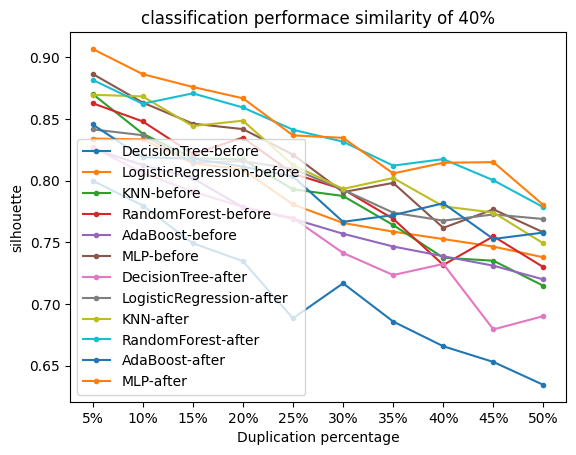

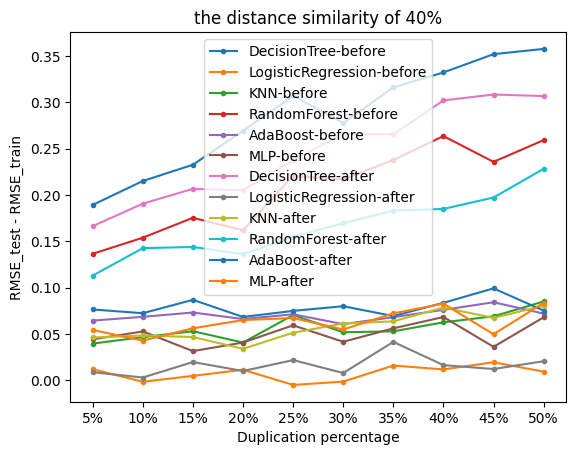

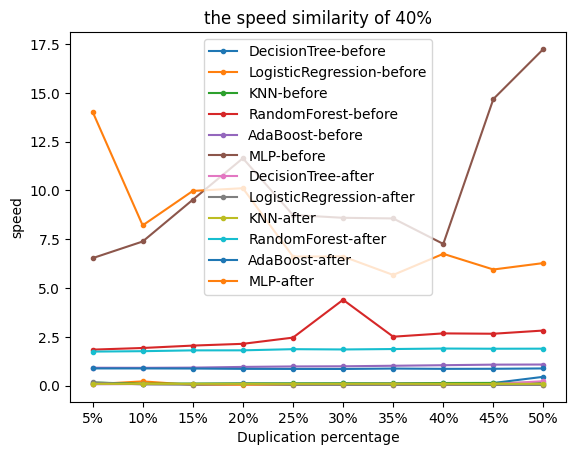

In [23]:

plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm, title="classification performace similarity of 40%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm,title="the distance similarity of 40%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm,title="the speed similarity of 40%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")


## 80 percent similarity plots

In [24]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree-before","LogisticRegression-before","KNN-before","RandomForest-before","AdaBoost-before","MLP-before","DecisionTree-after","LogisticRegression-after","KNN-after","RandomForest-after","AdaBoost-after","MLP-after"]
DecisionTree_1=[]
LogisticRegression_1=[]
KNN_1=[]
RandomForest_1=[]
AdaBoost_1=[]
MLP_1=[]

DecisionTree_2=[]
LogisticRegression_2=[]
KNN_2=[]
RandomForest_2=[]
AdaBoost_2=[]
MLP_2=[]


similarity=80
for i in range(5,55,5):
  DecisionTree_1.append(results_1_analysis['DecisionTree'][similarity][i])
  LogisticRegression_1.append(results_1_analysis['LogisticRegression'][similarity][i])
  KNN_1.append(results_1_analysis['KNN'][similarity][i])
  RandomForest_1.append(results_1_analysis['RandomForest'][similarity][i])
  AdaBoost_1.append(results_1_analysis['AdaBoost'][similarity][i])
  MLP_1.append(results_1_analysis['MLP'][similarity][i])

  DecisionTree_2.append(results_2_analysis['DecisionTree'][similarity][i])
  LogisticRegression_2.append(results_2_analysis['LogisticRegression'][similarity][i])
  KNN_2.append(results_2_analysis['KNN'][similarity][i])
  RandomForest_2.append(results_2_analysis['RandomForest'][similarity][i])
  AdaBoost_2.append(results_2_analysis['AdaBoost'][similarity][i])
  MLP_2.append(results_2_analysis['MLP'][similarity][i])


results_for_each_algorithm=[DecisionTree_1,LogisticRegression_1,KNN_1,RandomForest_1,AdaBoost_1,MLP_1,DecisionTree_2,LogisticRegression_2,KNN_2,RandomForest_2,AdaBoost_2,MLP_2]


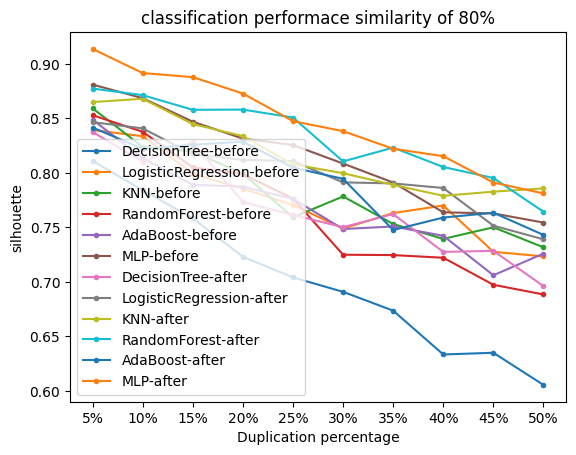

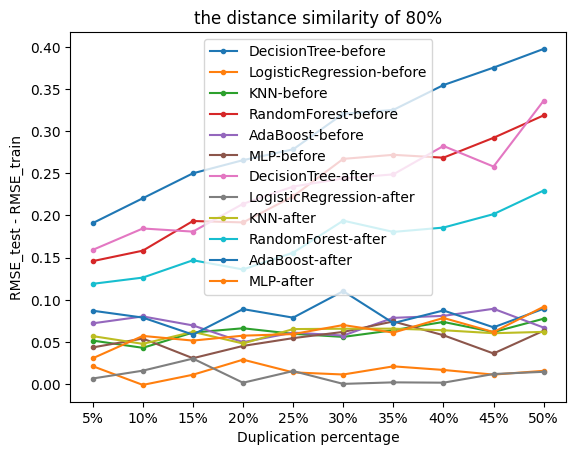

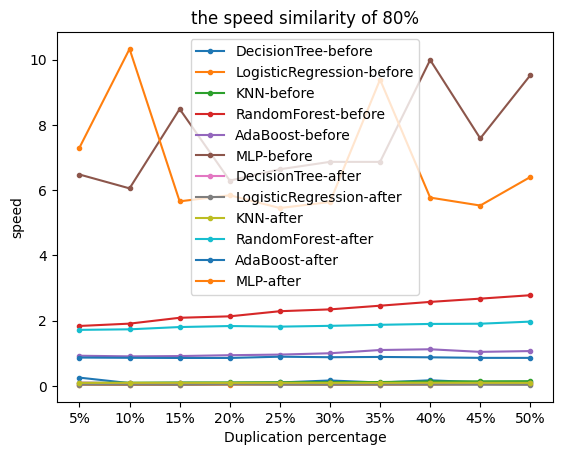

In [25]:

plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm, title="classification performace similarity of 80%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm,title="the distance similarity of 80%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=['5%','10%','15%','20%','25%','30%','35%','40%','45%','50%'], x_label="Duplication percentage", results=results_for_each_algorithm,title="the speed similarity of 80%", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")
